In [1]:
import sys

In [2]:
 print ('\n'.join(sys.path))


/usr/spark-2.2.0/python/lib/py4j-0.10.4-src.zip
/usr/spark-2.2.0/python
/usr/spark-2.2.0/python/build
/masvol/heartsmart/Volume
/usr/lib/python35.zip
/usr/lib/python3.5
/usr/lib/python3.5/plat-x86_64-linux-gnu
/usr/lib/python3.5/lib-dynload
/usr/local/lib/python3.5/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.5/dist-packages/IPython/extensions
/root/.ipython


In [3]:
import json
import numpy as np
import dicom
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import random
import volume_final_working as vfw
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sn

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
v_dir = '/masvol/output/dsb/volume/'
# dirs = ['3combined_1_3_0_176_CLAHE_augx_bn_bce1_crERDS2',
#     '3combined_1_3_0_176_CLAHE_augx_drop_ld1_crERDS2',
#     '3combined_1_3_0_176_CLAHE_augx_drop_bce1_crERDS2',
#         '3combined_1_3_0_176_CLAHE_augx_bce1_crERDS2',
#        '3combined_1_3_0_176_aug_drop_dice_crERDS2']
# dirs = ['3combined_1_3_0_176_CLAHE_augx_bn_bce1_crERDS2',
#        '3combined_1_3_0_176_CLAHE_augx_drop_bce1_crERDS2']

# dirs = ['3top_test_vote','3combined_1_3_0_176_aug_drop_dice_crERDS2']
dirs = ['3combined_1_3_0_176_CLAHE_augx_bn_bce1_crERDS2',
        '3combined_1_3_0_176_CLAHE_augx_drop_bce1_crERDS2']

In [5]:
sys_v = vfw.computeVolume(v_dir+'1/'+dirs[1]+'/',176, vtype='zeros',STway='sub', ty=None, rls = None, stcheck = None)
v = vfw.computeVolume(v_dir+'1/'+dirs[0]+'/',176, vtype='zeros',STway='sub', ty=None, rls = 'Yes', stcheck = None)

In [6]:
test_gt = pd.read_csv('/masvol/data/dsb/solution.csv')

In [7]:
def create_test_df(Volumes):
    test_gt = pd.read_csv('/masvol/data/dsb/solution.csv')
    
    test_pred = []

    for i in Volumes:
        if ('test') in i:
            ID = i.strip('test_')
            ESV = Volumes[i]['ESV']
            EDV = Volumes[i]['EDV']
            age = Volumes[i]['issues'][ID]['age']
            age_unit = age[-1]
            age_int = int(age[:-1])
            gender = Volumes[i]['issues'][ID]['gender']
            slices = Volumes[i]['issues'][ID]['numSlices']
#             print (slices,Volumes[i]['issues'][ID]['numSlices'] )
            test_pred.append([int(ID), ESV, EDV,age, age_int, age_unit, gender,slices])
#             print (i,ID)
#             train_pred.append([int(ID), ESV, EDV])
#         if ('validate') in i:
#             ID = i.strip('validate_')
#             ESV = Volumes[i]['ESV']
#             EDV = Volumes[i]['EDV']
#             age = Volumes[i]['issues'][ID]['age']
#             age_unit = age[-1]
#             age_int = int(age[:-1])
#             gender = Volumes[i]['issues'][ID]['gender']
#             slices = Volumes[i]['issues'][ID]['numSlices']
#             validate_pred.append([int(ID), ESV, EDV,age, age_int, age_unit, gender,slices])
#             print (i,ID)
#             validate_pred.append([int(ID), ESV, EDV])
    test_pred_df = pd.DataFrame(test_pred, columns= ['Id','Systole_P', 'Diastole_P',
                                                       'Age','Age_Int','Age Unit', 'Gender','NumSlices']).set_index('Id',drop=False)

# #     validate_pred_df = pd.DataFrame(validate_pred, columns= ['Id','Systole_P', 'Diastole_P',
# #                                                             'Age','Age_Int','Age Unit','Gender',
# #                                                              'NumSlices'])
#     train_df = pd.concat([train_gt.set_index('Id'),train_pred_df.set_index('Id')], axis=1, join='inner')
#     train_df['Systole_diff'] = train_df['Systole'] - train_df['Systole_P']
#     train_df['Diastole_diff'] = train_df['Diastole'] - train_df['Diastole_P']
#     train_df['EF_P'] = (train_df['Diastole_P']-train_df['Systole_P'])/train_df['Diastole_P']
#     train_df['EF'] = (train_df['Diastole']-train_df['Systole'])/train_df['Diastole']
#     validate_df = pd.concat([validate_gt.set_index('Id'),validate_pred_df.set_index('Id')], axis=1, join='inner')
#     validate_df['Systole_diff'] = validate_df['Systole'] - validate_df['Systole_P']
#     validate_df['Diastole_diff'] = validate_df['Diastole'] - validate_df['Diastole_P']
# #     validate_df['EF_P'] = (validate_df['Diastole_P']-validate_df['Systole_P'])/validate_df['Diastole_P']
# #     validate_df['EF'] = (validate_df['Diastole']-validate_df['Systole'])/validate_df['Diastole']
#     all_df = pd.concat([train_df, validate_df], axis=0)
    
    return (test_pred_df)

In [8]:
# Gets the dataframes for the diastole and systole models
t = create_test_df(v).sort_values(by = 'Id')
# t['EF'] = (t['Diastole']-t['Systole'])/t['Diastole']
# t['EF_P'] = (t['Diastole_P']-t['Systole_P'])/t['Diastole_P']
sys_t = create_test_df(sys_v).sort_values(by = 'Id')

In [9]:
t.head()

,Id,Systole_P,Diastole_P,Age,Age_Int,Age Unit,Gender,NumSlices
Id,,,,,,,,
701,701,61.230012,174.715029,042Y,42,Y,F,11
702,702,36.125461,107.941470,010Y,10,Y,M,11
703,703,30.170013,91.450039,028Y,28,Y,F,9
704,704,85.694971,209.889926,049Y,49,Y,M,10
705,705,42.209994,117.739984,020Y,20,Y,F,9


In [10]:
# all_no_outliers = vfw.removeOutliers(sys_t,v, data='test')
# print (all_no_outliers.columns)
# test = vfw.removeLowEstimates(all_no_outliers, data = 'test')
# print (test.columns)
# all_no_out_noVol = vfw.removeNoVolume(test)
# sys, dia, ef = vfw.compute_rmse(all_no_out_noVol, 'all')

In [11]:
#Columns that are wanted from each model's dataframe
dia_cols = ['Id','Age','Age_Int','Age Unit','Gender','NumSlices', 'Diastole_P']
sys_cols = ['Age','Age_Int','Age Unit','Gender', 'Systole_P']

In [12]:
# Creating the merged dataframe with the Diastole Predictions from Diastole Model and Systole 
# Predications from Systole Model
tmp = t[dia_cols].copy()
tmp['Systole_P'] = sys_t['Systole_P']

In [13]:
tmp.head()

,Id,Age,Age_Int,Age Unit,Gender,NumSlices,Diastole_P,Systole_P
Id,,,,,,,,
701,701,042Y,42,Y,F,11,174.715029,52.985015
702,702,010Y,10,Y,M,11,107.941470,44.289000
703,703,028Y,28,Y,F,9,91.450039,26.655011
704,704,049Y,49,Y,M,10,209.889926,84.074971
705,705,020Y,20,Y,F,9,117.739984,45.939994


In [14]:
# tmp['EF'] = (tmp['Diastole']-tmp['Systole'])/tmp['Diastole']
# tmp['EF_P'] = (tmp['Diastole_P']-tmp['Systole_P'])/tmp['Diastole_P']

In [14]:
#Remove the Outliers and calculate the volume based on the Gender / Age model
# all_no_outliers = vfw.removeOutliers(tmp,v, data='test')
# print (all_no_outliers.columns)
# Remove low estimates with the Gender / Age Model
# test = vfw.removeLowEstimates(tmp, data='test')
test = vfw.removeLowEstimatesDSBLR(tmp, data='test')
print (test.columns)
# Check to make sure not volumes are zero
all_no_out_noVol = vfw.removeNoVolume(test)
# sys, dia, ef = vfw.compute_rmse(all_no_out_noVol, 'all')
all_no_out_noVol['Diasotle Model'] = dirs[0]
all_no_out_noVol['Systole Model'] = dirs[1]

Index(['Id', 'Age', 'Age_Int', 'Age Unit', 'Gender', 'NumSlices', 'Diastole_P',
       'Systole_P'],
      dtype='object')
Index(['Id', 'Age', 'Age_Int', 'Age Unit', 'Gender', 'NumSlices', 'Diastole_P',
       'Systole_P'],
      dtype='object')


/masvol/heartsmart/Volume/volume_final_working.py:855: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'Systole_P', new_vol, takeable=False)
/masvol/heartsmart/Volume/volume_final_working.py:864: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'Systole_P', new_vol, takeable=False)
/masvol/heartsmart/Volume/volume_final_working.py:863: RuntimeWarning: divide by zero encountered in double_scalars
  ef_p = ((df.loc[i]['Diastole_P'] - new_vol) / df.loc[i]['Diastole_P'])
/masvol/heartsmart/Volume/volume_final_working.py:872: RuntimeWarning: divide by zero encountered in double_scalars
  ef_p = ((df.loc[i]['Diastole_P'] - new_vol) / df.loc[i]['Diastole_P'])
/masvol/heartsmart/Volume/volume_final_working.py:873: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[

In [15]:
# Get the Testing Actual Volumes into a Dictionary
soln = {}
for index, row in test_gt.iterrows():
    print (row['Id'], row['Volume'])
    split = row['Id'].split('_')
    Id = split[0]
    vol_type = split[1]
    volume_a = row['Volume']
    if Id in soln:
        d_vol = soln[Id]['Diastole']
        soln[Id].update({'Id': int(Id),
                         'Diastole': d_vol,
                         'Systole': volume_a})
    else:
        soln[Id] = {'Id': int(Id),
                    'Diastole': volume_a,
                   'Systole': 'null'}

1000_Diastole 113.1
1000_Systole 38.1
1001_Diastole 141.5
1001_Systole 59.0
1002_Diastole 130.8
1002_Systole 60.5
1003_Diastole 180.2
1003_Systole 72.8
1004_Diastole 135.8
1004_Systole 61.3
1005_Diastole 113.2
1005_Systole 45.1
1006_Diastole 163.6
1006_Systole 58.5
1007_Diastole 122.0
1007_Systole 47.0
1008_Diastole 163.3
1008_Systole 75.9
1009_Diastole 123.0
1009_Systole 48.0
1010_Diastole 95.4
1010_Systole 32.2
1011_Diastole 250.0
1011_Systole 106.2
1012_Diastole 227.0
1012_Systole 95.0
1013_Diastole 125.4
1013_Systole 45.0
1014_Diastole 126.5
1014_Systole 45.5
1015_Diastole 120.5
1015_Systole 54.8
1016_Diastole 208.6
1016_Systole 155.5
1017_Diastole 190.7
1017_Systole 93.5
1018_Diastole 217.9
1018_Systole 83.6
1019_Diastole 169.6
1019_Systole 63.5
1020_Diastole 188.4
1020_Systole 65.1
1021_Diastole 126.2
1021_Systole 57.9
1022_Diastole 103.0
1022_Systole 44.1
1023_Diastole 142.7
1023_Systole 57.5
1024_Diastole 144.6
1024_Systole 60.4
1025_Diastole 157.4
1025_Systole 56.9
1026_Diasto

In [16]:
# Turn actual Predictions into a Dataframe
a = pd.DataFrame.from_dict(soln, orient = 'index').sort_values(by='Id')

In [17]:
# Get Actual Diastole and Systole Values
dia = a['Diastole'].values
sys = a['Systole'].values

In [18]:
# Add the actual values to the columns of the predicted dataframe
all_no_out_noVol['Diastole'] = dia
all_no_out_noVol['Systole'] = sys

In [19]:
# Cacluate the EF and EF predicted
all_no_out_noVol['EF'] = (all_no_out_noVol['Diastole']-all_no_out_noVol['Systole'])/all_no_out_noVol['Diastole']
all_no_out_noVol['EF_P'] = (all_no_out_noVol['Diastole_P']-all_no_out_noVol['Systole_P'])/all_no_out_noVol['Diastole_P']

In [20]:
all_no_out_noVol.loc[all_no_out_noVol['Systole'].isnull()]

,Id,Age,Age_Int,Age Unit,Gender,NumSlices,Diastole_P,Systole_P,Diasotle Model,Systole Model,Diastole,Systole,EF,EF_P
Id,,,,,,,,,,,,,,


In [21]:
# all_no_out_noVol.to_csv('TMP.csv')

In [22]:
# Calculate the RMSE
sys, dia, ef = vfw.compute_rmse(all_no_out_noVol, 'all')

all :  Systole RMSE: 15.25 ml  Diastole RMSE: '16.95 ml  EF RMSE: 11.00 %


In [385]:
all_no_out_noVol['EF_P']all_no_out_noVol['EF_P'].min()

-0.13029225075691514

In [386]:
all_no_out_noVol.loc[all_no_out_noVol['EF_P'] == all_no_out_noVol['EF_P'].min()]

,Id,Age,Age_Int,Age Unit,Gender,NumSlices,Diastole_P,Systole_P,Diasotle Model,Systole Model,Diastole,Systole,EF,EF_P
Id,,,,,,,,,,,,,,
875,875,006M,6,M,F,11,14.337,16.205,3combined_1_3_0_176_CLAHE_augx_bn_bce1_crERDS2,3combined_1_3_0_176_CLAHE_augx_drop_bce1_crERDS2,19.8,8.5,0.570707,-0.130292


In [233]:
# all_no_out_noVol.to_csv('Final_Volume_pred.csv')

In [344]:
def plotting (df, actual, predicted):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[predicted], df[actual],color = 'lightblue')
    plt.plot(range(len(df[predicted])), range(len(df[actual])), color = 'black')
    plt.xlabel('Predicted '+ actual)
    plt.ylabel('Actual ' +actual)
    plt.xlim(0,400)
    plt.ylim(0, 400)
#     plt.title('Actual vs. Predicted Ejection Fraction')
    plt.title('Actual vs. Predicted End '+actual+' Volume')

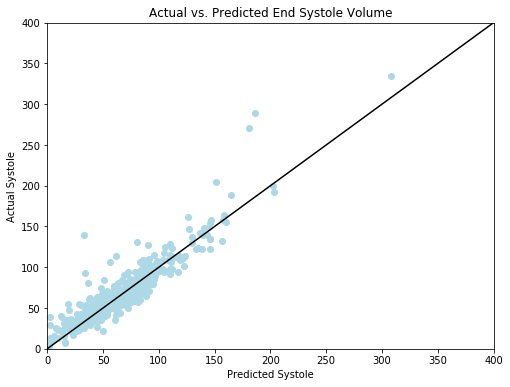

In [345]:
plotting(all_no_out_noVol, 'Systole','Systole_P')
plt.savefig('Actual_Systole_vs_Predicted.png')

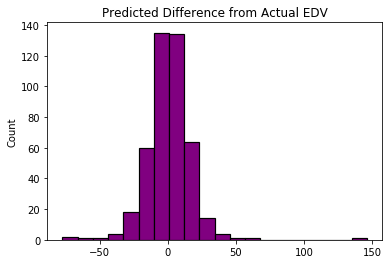

In [346]:
plt.hist((all_no_out_noVol['Diastole'] - all_no_out_noVol['Diastole_P']), color='purple', bins=20,edgecolor='black', linewidth=1.2)
plt.title('Predicted Difference from Actual EDV')
plt.ylabel('Count')
plt.savefig('Diastole_Diff_Hist.png')

In [ ]:
all_no_out_noVol.loc[all_no_out_noVol['']]

In [439]:
def Display_EF_classification(EF_true,EF_predicted,cmap='Reds'):
    bins = [0,0.35, 0.45, 0.55, 0.73,1]
    EF_true=np.abs(EF_true)
    EF_predicted=np.abs(EF_predicted)
    labels = ['Sev  Abnormal <35%', 'Mod  Abnormal 35%-45%', 'Mild  Abnormal 45%-55%', 'Normal 55%-73%','Hyperdynamic >73%']
    y_true=pd.cut(EF_true, bins=bins, labels=labels)
    print (y_true)
    y_pred=pd.cut(EF_predicted, bins=bins, labels=labels)
    print (y_pred)
    cnf_matrix=confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cnf_matrix, index = labels,columns = labels)
    plt.figure(figsize = (12,10))
    sn.set(font_scale=1.6)
    ax = sn.heatmap(df_cm, annot=True,fmt="d",cmap=cmap,annot_kws={"size": 20})
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.xlabel('Predicted Category',fontsize=20)
    plt.ylabel('True Category',fontsize=20)

[Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, ..., Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%]
Length: 440
Categories (5, object): [Sev  Abnormal <35% < Mod  Abnormal 35%-45% < Mild  Abnormal 45%-55% < Normal 55%-73% < Hyperdynamic >73%]
[Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, ..., Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%, Normal 55%-73%]
Length: 440
Categories (5, object): [Sev  Abnormal <35% < Mod  Abnormal 35%-45% < Mild  Abnormal 45%-55% < Normal 55%-73% < Hyperdynamic >73%]


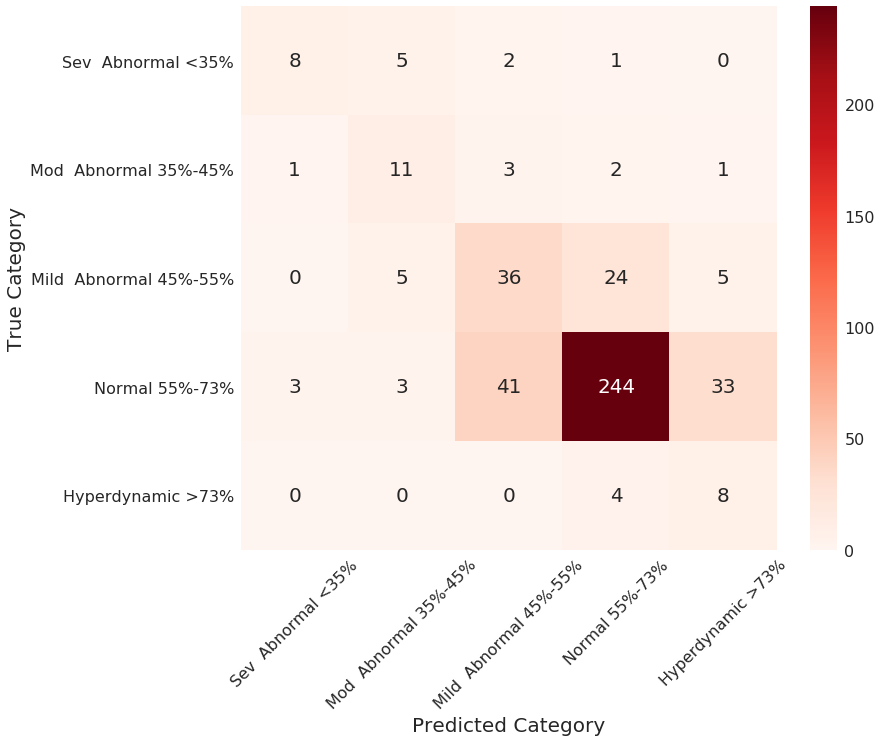

In [440]:
Display_EF_classification(all_no_out_noVol['EF'].values, all_no_out_noVol['EF_P'].values)

In [391]:
sn.heatmap?